In [1]:
import pandas as pd
import openpyxl

## Collecting and Preprocessing Data for Portfolio

My sample portfolio is very tech heavy, consisting of major companies. The data was extracted from Kaggle.

In [2]:
tickers = ['AMZN', 'GOOGL', 'IBM', 'META', 'MSFT', 'NVDA', 'AAPL']
Original_weights = pd.Series({'AMZN':0.12, 'GOOGL':0.16, 'IBM':0.04, 'META':0.27, 'MSFT':0.19, 'NVDA':0.19, 'AAPL': 0.03})

# NVDA = Date (Jan 1999 - Feb 2025), Adj Close, Close, High, Low, Open, Volume
# META = Date (May 2012 - Jan 2025), Open, High, Low, Close, Adj Close, Volume
# GOOGL = Date (Aug 2004 - Dec 2024), Open, High, Low, Close, Adj Close, Volume
# AMZN = Date (Jan 2000 - Feb 2025), Open, High, Low, Close, Adj Close, Volume
# IBM = Date (Jan 1980 - Jul 2025), Open, High, Low, Close, Adj Close, Volume, Dividends, Stock Splits, Adj Factor
# MSFT = Date (Mar 1986 - Feb 2025), Open, High, Low, Close, Adj Close, Volume
# AAPL = Date (Dec 1980 - Jan 2025), Adj Close, Close, High, Low, Open, Volume

initial_date = '2012-05-18'
latest_date = '2024-12-17'

Portfolio = []
for tick in tickers:
    stock = pd.read_csv(f'Data/{tick}.csv')

    if tick == 'AMZN':
        stock = stock.rename(columns={'date':'Date', 'adj_close':'Adj Close'}) #Renaming date to Date
        stock['Date'] = (pd.to_datetime(stock['Date'], utc=True)).dt.date #Turning to required format
    
    if tick == 'IBM':
        stock = stock.drop(labels=['Dividends', 'Stock Splits', 'Adj Factor'], axis=1)#Dropping unecessary columns

    if tick == 'AAPL':
        stock = stock.rename(columns={'Unnamed: 0':'Date'})

    stock = stock.rename(columns={col: f"{tick}.{col}" for col in stock.columns if col != 'Date'}) #renaming with stock prefix
        
    stock['Date'] = pd.to_datetime(stock['Date'], format='%Y-%m-%d')
    
    stock = stock.loc[(stock['Date'] >= initial_date) & (stock['Date'] <= latest_date)] #Filtering by overlapping dates

    stock['Date'] = stock['Date'].dt.date

    stock.set_index('Date', inplace=True) #Use date as index
    
    
    Portfolio.append(stock)

Stock_Data = pd.concat(Portfolio, axis=1)

In [3]:
print(Stock_Data)

             AMZN.open   AMZN.high    AMZN.low  AMZN.close  AMZN.Adj Close  \
Date                                                                         
2012-05-18   10.970500   10.981500   10.640500   10.692500       10.692500   
2012-05-21   10.701500   10.999000   10.641000   10.905500       10.905500   
2012-05-22   10.915500   10.943500   10.698000   10.766500       10.766500   
2012-05-23   10.735500   10.877500   10.559000   10.864000       10.864000   
2012-05-24   10.849000   10.883000   10.635000   10.762000       10.762000   
...                ...         ...         ...         ...             ...   
2024-12-11  226.410004  231.199997  226.259995  230.259995      230.259995   
2024-12-12  229.830002  231.089996  227.630005  228.970001      228.970001   
2024-12-13  228.399994  230.199997  225.860001  227.460007      227.460007   
2024-12-16  230.229996  233.000000  228.009995  232.929993      232.929993   
2024-12-17  232.389999  232.729996  227.850006  231.149994      

# Calculating expected returns & covariance matrix

Using exponentially weighted mean historical returns for expected returns calculation, this is similar to mean historical returns, except it gives exponentially more weight to recent prices. This is useful because it is likely the case that an asset's most recent returns hold more weight than returns from 10 years ago when it comes to estimating future returns.

The covariance matrix encodes not just the volatility of an asset, but also how it correlated to other assets. This is important because in order to reap the benefits of diversification (and thus increase return per unit risk), the assets in the portfolio should be as uncorrelated as possible. For this implementation we will use exponential covariance: an improvement over sample covariance that gives more weight to recent data.


Exponentially Weighted Mean Historical Returns:
 AMZN.EWMHR     0.277259
GOOGL.EWMHR    0.226973
IBM.EWMHR      0.060301
META.EWMHR     0.248650
MSFT.EWMHR     0.266422
NVDA.EWMHR     0.632348
AAPL.EWMHR     0.246170
dtype: float64


Exponential Coveriance Matrix:
            AMZN      NVDA      META     GOOGL      MSFT       IBM      AAPL
AMZN   0.084833  0.059675  0.049859  0.045051  0.038221  0.012593  0.019642
NVDA   0.059675  0.241288  0.061582  0.042544  0.045752  0.019141  0.028207
META   0.049859  0.061582  0.094278  0.041748  0.035672  0.012307  0.021305
GOOGL  0.045051  0.042544  0.041748  0.083253  0.028494  0.000365  0.018701
MSFT   0.038221  0.045752  0.035672  0.028494  0.039978  0.007621  0.020119
IBM    0.012593  0.019141  0.012307  0.000365  0.007621  0.048768  0.004175
AAPL   0.019642  0.028207  0.021305  0.018701  0.020119  0.004175  0.042677




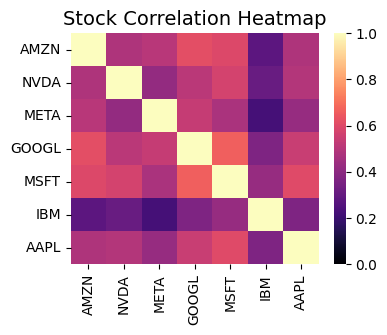

In [4]:
from pypfopt import expected_returns
from pypfopt import risk_models
import seaborn as sns
import matplotlib.pyplot as plt

EWM_Returns_List = []
Subset_Adj_Close = Stock_Data[['AMZN.Adj Close', 'NVDA.Adj Close', 'META.Adj Close', 'GOOGL.Adj Close', 'MSFT.Adj Close', 'IBM.Adj Close', 'AAPL.Adj Close']]
Exp_Cov_Matrix = (risk_models.exp_cov(Subset_Adj_Close))
Perc_Change_Stock = Subset_Adj_Close.pct_change()

#Mostly renaming
for tick in tickers:
    EWMR_Stock = (expected_returns.mean_historical_return(Stock_Data[[f'{tick}.Adj Close']]))
    EWMR_Stock = EWMR_Stock.rename({f'{tick}.Adj Close':f'{tick}.EWMHR'})
    EWM_Returns_List.append(EWMR_Stock)

    Exp_Cov_Matrix = Exp_Cov_Matrix.rename({f'{tick}.Adj Close':f'{tick}'}, axis=1)
    Exp_Cov_Matrix = Exp_Cov_Matrix.rename({f'{tick}.Adj Close':f'{tick}'}, axis=0)

    Perc_Change_Stock = Perc_Change_Stock.rename({f'{tick}.Adj Close':f'{tick}'}, axis=1)
    Perc_Change_Stock = Perc_Change_Stock.rename({f'{tick}.Adj Close':f'{tick}'}, axis=0)


EWM_Returns = pd.concat(EWM_Returns_List, axis=0)
print("Exponentially Weighted Mean Historical Returns:\n", EWM_Returns)
print("\n")


print("Exponential Coveriance Matrix:\n", Exp_Cov_Matrix)
print("\n")

corr_matrix = Perc_Change_Stock.corr()

plt.figure(figsize=(4,3))
sns.heatmap(corr_matrix, cmap="magma", vmin=0, vmax=1, annot=False, cbar=True)

plt.title("Stock Correlation Heatmap", fontsize=14)
plt.show()

#

Sharpe Ratio = Risk-adjusted return rate, i.e: Per unit of risk how much return are we getting?


Efficient Frontier = A curve that demonstrates the best portfolios for different levels of risk.

In [5]:
from pypfopt import EfficientFrontier

Max_Sharpe_Weights = pd.Series(EfficientFrontier(EWM_Returns, Exp_Cov_Matrix).max_sharpe())
Min_Volatility_Weights = pd.Series(EfficientFrontier(EWM_Returns, Exp_Cov_Matrix).min_volatility())

for tick in tickers:
    Max_Sharpe_Weights = Max_Sharpe_Weights.rename({f'{tick}.EWMHR':f'{tick}'})
    Min_Volatility_Weights = Min_Volatility_Weights.rename({f'{tick}.EWMHR':f'{tick}'})

print("Original Weights:\n", Original_weights)
print("\n")
print("Max Sharpe Weights:\n", Max_Sharpe_Weights)
print("\n")
print("Min Volatility Weights:\n", Min_Volatility_Weights)


Original Weights:
 AMZN     0.12
GOOGL    0.16
IBM      0.04
META     0.27
MSFT     0.19
NVDA     0.19
AAPL     0.03
dtype: float64


Max Sharpe Weights:
 AMZN     0.000000
GOOGL    0.000000
IBM      0.000000
META     0.091758
MSFT     0.080533
NVDA     0.663481
AAPL     0.164228
dtype: float64


Min Volatility Weights:
 AMZN     0.000000
GOOGL    0.000000
IBM      0.000000
META     0.104123
MSFT     0.227489
NVDA     0.366888
AAPL     0.301500
dtype: float64


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2012-05-21   2012-05-21
End Period                 2024-12-17   2024-12-17
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          4,023.55%    7,552.04%
CAGR﹪                     34.46%       41.25%

Sharpe                     1.25         1.35
Prob. Sharpe Ratio         100.0%       100.0%
Smart Sharpe               1.14         1.23
Sortino                    1.82         2.01
Smart Sortino              1.66         1.83
Sortino/√2                 1.29         1.42
Smart Sortino/√2           1.18         1.29
Omega                      1.28         1.28

Max Drawdown               -53.14%      -46.25%
Max DD Date                2022-11-03   2022-10-14
Max DD Period Start        2021-11-22   2021-12-28
Max DD Period End          2023-06-14   2023-05-24
Longest DD Days            570          513


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-12-28,2022-10-14,2023-05-24,513,-46.254180,-44.909600
2,2018-10-04,2018-12-24,2019-10-25,387,-39.044738,-35.589561
3,2020-02-20,2020-03-16,2020-05-08,79,-31.164591,-30.658483
4,2015-12-07,2016-02-08,2016-03-28,113,-18.493884,-18.449095
5,2012-09-20,2013-04-18,2013-08-01,316,-17.021725,-16.384442


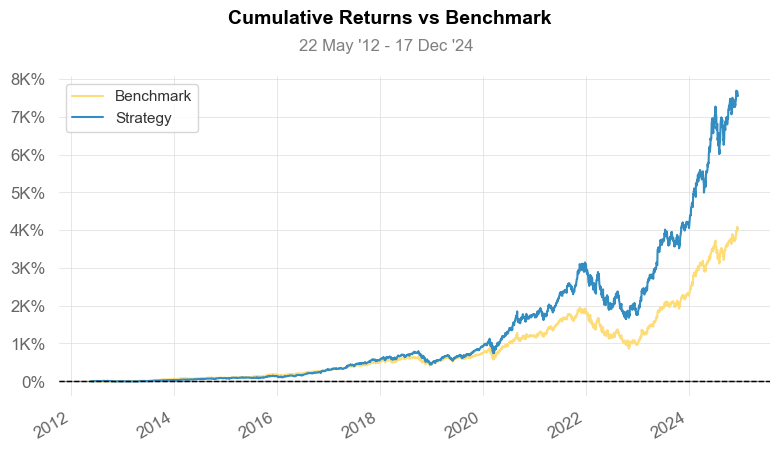

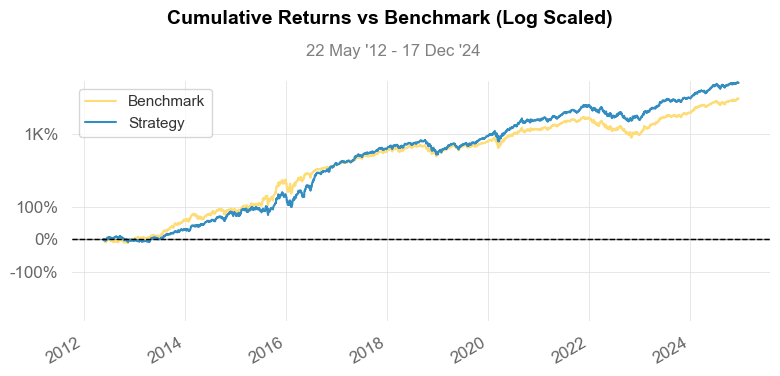

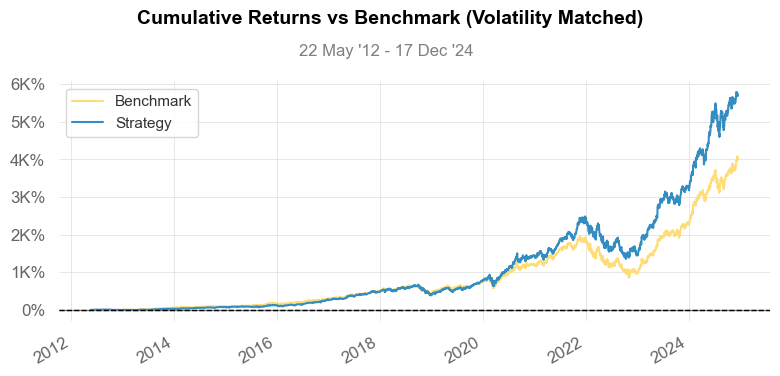

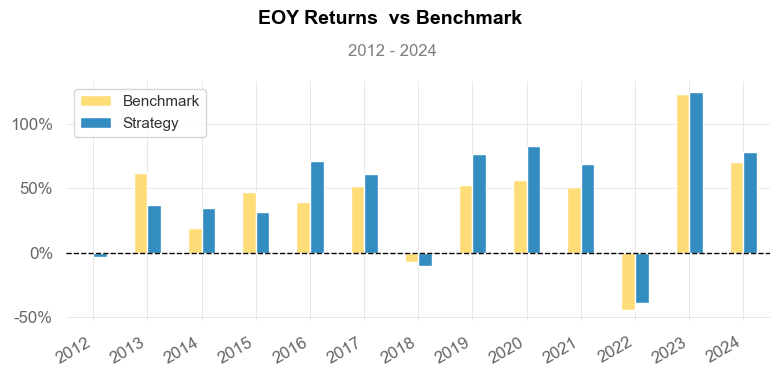

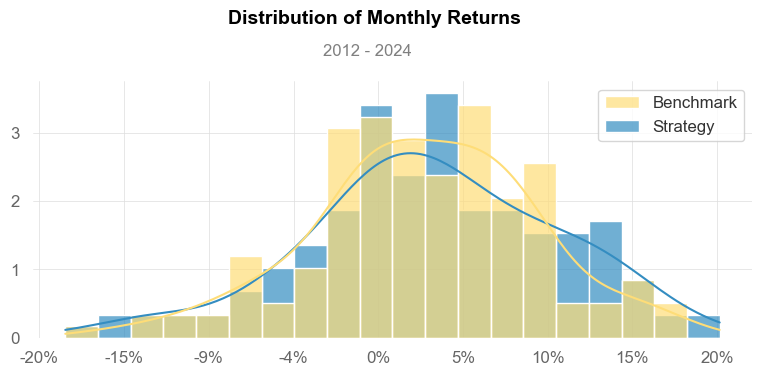

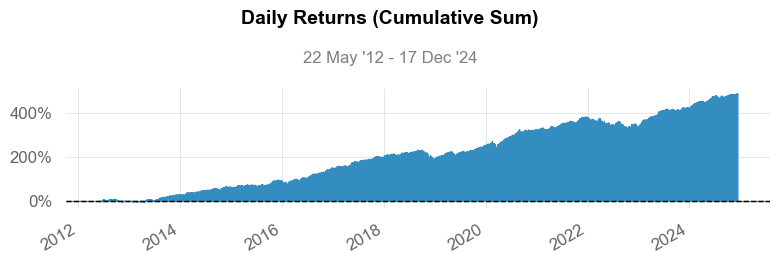

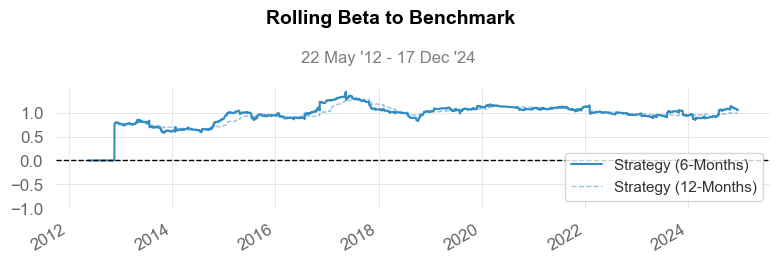

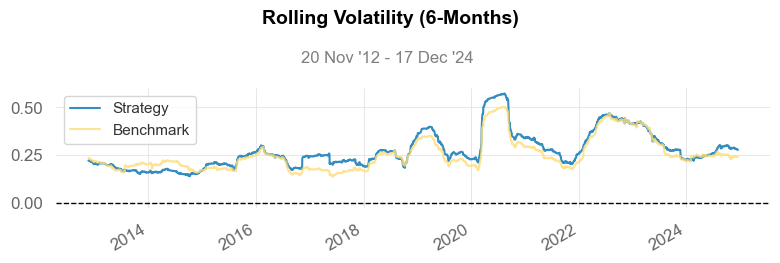

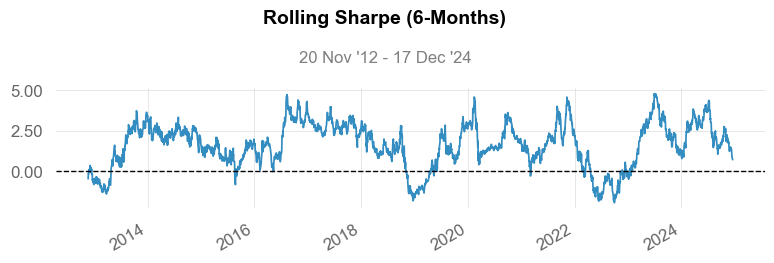

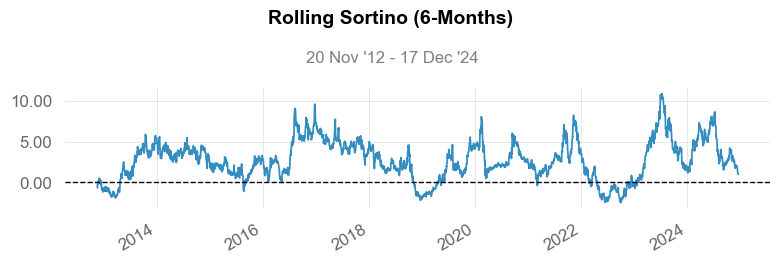

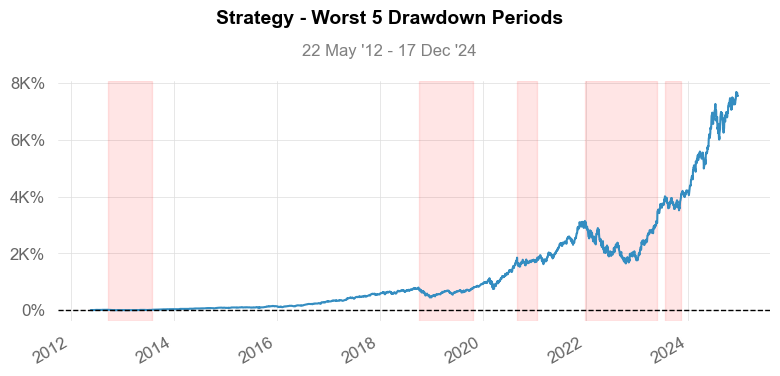

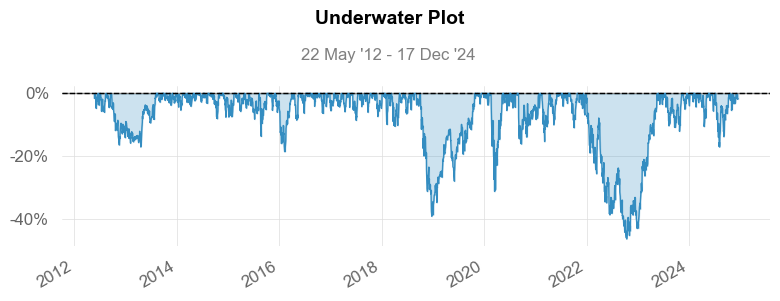

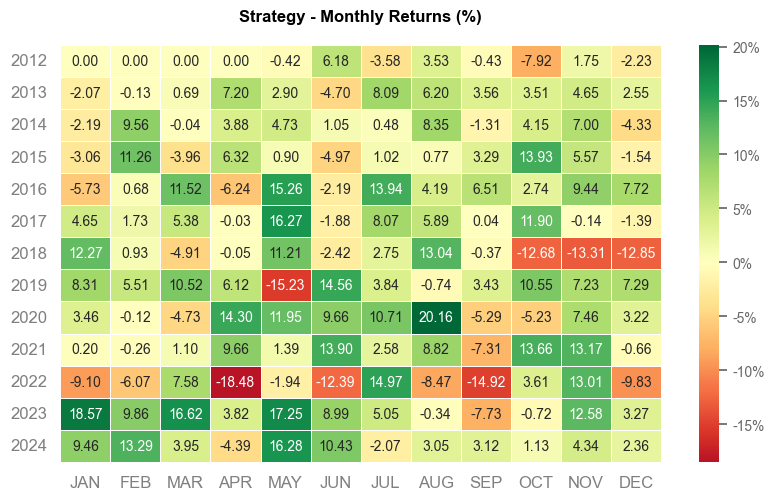

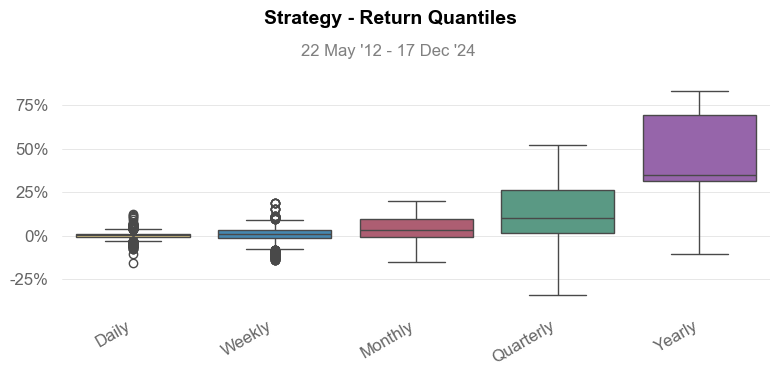

In [6]:
import quantstats as qs

#Create returns dataframe for each stock
Perc_Returns = Perc_Change_Stock.dropna()

# Apply weights to daily returns
actual_portfolio_returns = Perc_Returns.dot(Original_weights)
optimized_Max_Sharpe_portfolio_returns = Perc_Returns.dot(Max_Sharpe_Weights)
optimized_Min_Volatility_portfolio_returns = Perc_Returns.dot(Min_Volatility_Weights)

qs.reports.full(optimized_Min_Volatility_portfolio_returns, benchmark=actual_portfolio_returns)